In [1]:
import os
import time
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
# from torch import cdist
# import glob

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import umap
# from statsmodels.tsa.arima.model import ARIMA

/Users/dashtbozorgi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dashtbozorgi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [ ]:
import EncoderFactory
from DatasetManager import DatasetManager

In [7]:
case_id_col = "UID"
timestamp_col = "Timestamp"
target_col = "Titer (g/L)"
work_day_col = "Work_Day_Index"

In [12]:
df = pd.read_csv('data/processed/databricks_preprocessed_forTiter_notNormalised_7Jan25.csv')
df[case_id_col].nunique()

125

In [ ]:
# Convert Timestamp column to datetime
df[timestamp_col] = pd.to_datetime(df[timestamp_col])

In [ ]:
bad_timestamps = df[df[timestamp_col].dt.year <= 2000][case_id_col].unique()

In [ ]:
def correct_date_string(date_string):
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:8]

    # Validate and correct the month
    if int(month) < 1 or int(month) > 12:
        month = "02"  # Default to February for correction

    # Validate and correct the day
    if int(day) < 1 or int(day) > 31:
        day = "27"  # Default to 27th for correction

    corrected_date_string = year + month + day
    return corrected_date_string

In [ ]:
for timestamp in bad_timestamps:
    date_string = timestamp[:8]  # Extract the date portion: "20230101"
    corrected_date_string = correct_date_string(date_string)
    date_format = "%Y%m%d"

    # Convert the corrected date string to a datetime object
    corrected_date = datetime.strptime(corrected_date_string, date_format)
    # Replace the timestamp with the corrected date
    # print(f"Correcting {date_string} to {corrected_date}")
    df.loc[df[case_id_col] == timestamp, timestamp_col] = corrected_date

In [ ]:
df[timestamp_col] = pd.to_datetime(df[timestamp_col])

In [ ]:
earliest_timestamp = df['Timestamp'].min()
latest_timestamp = df['Timestamp'].max()

print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)


In [ ]:
df = df.sort_values(by=[case_id_col, work_day_col])

##############################################################################

In [ ]:
df_normalized = df.copy()

In [ ]:
# df_normalized = pd.read_csv('data/processed/databricks_preprocessed_forTiter_notNormalised.csv')

In [ ]:
df_normalized['range_indicator'] = df_normalized.groupby(case_id_col)[target_col].transform(lambda x: 1 if x.max() > 5 else 0)


In [ ]:
# Check if 'range_indicator' is 1
mask = df_normalized['range_indicator'] == 1

# Convert mg/L to g/L for column A
df_normalized.loc[mask, target_col] = df_normalized.loc[mask, target_col] / 1000

In [8]:
columns_to_normalize = ['Viability (%)', 'Viable Cell Density (1E06 cells/mL)', 'Glucose (g/L)', 'Lactate (g/L)', 'Temperature (ºC)',
                        'DO (%) [controlling probe]', 'Cumulative IVCD (1E06 cells*day/mL)', 'pH', 'Glutamine (g/L)', 'Glutamate (g/L)',
                        'Ammonia (g/L)', 'Sodium (g/L)', 'Potassium (g/L)', 'Calcium (g/L)', target_col]

In [ ]:
from sklearn.preprocessing import StandardScaler

scalers = {}
# Create a StandardScaler object
scaler = StandardScaler()

for column in columns_to_normalize:
    scalers[column] = StandardScaler()
    df_normalized[column] = scalers[column].fit_transform(df_normalized[[column]])

# Normalize the selected columns
# df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])


In [ ]:
df_normalized['Titer (g/L) original'] = scalers[target_col].inverse_transform(df_normalized[target_col].to_numpy().reshape(-1, 1))

In [ ]:
df_normalized['Titer (g/L) original'].describe()

In [ ]:
# df_normalized.to_csv('data/processed/databricks_preprocessed_forTiter_normalised_7Jan25.csv', index=False)
df_normalized.to_csv('data/processed/databricks_preprocessed_forTiter_normalised_3Feb25.csv', index=False)

##############################################################################

In [5]:
df_normalized = pd.read_csv('data/processed/databricks_preprocessed_forTiter_normalised_3Feb25.csv')

In [9]:
features = [x for x in columns_to_normalize if x != target_col]
print(features)  

['Viability (%)', 'Viable Cell Density (1E06 cells/mL)', 'Glucose (g/L)', 'Lactate (g/L)', 'Temperature (ºC)', 'DO (%) [controlling probe]', 'Cumulative IVCD (1E06 cells*day/mL)', 'pH', 'Glutamine (g/L)', 'Glutamate (g/L)', 'Ammonia (g/L)', 'Sodium (g/L)', 'Potassium (g/L)', 'Calcium (g/L)']


In [10]:
len(features)

14

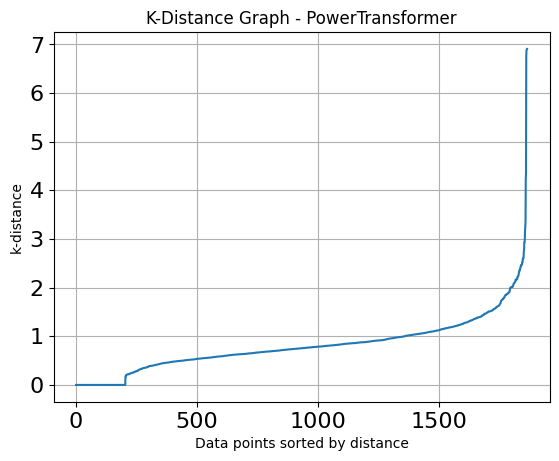

In [14]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer, Normalizer

# Sample data
data = df[features]  # Replace with your actual data
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = MaxAbsScaler()
scaler = PowerTransformer()
# scaler = Normalizer()
# scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(data)

# Fit nearest neighbors
k = 5  # Choose k as min_samples for DBSCAN
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.ylabel('k-distance')
plt.xlabel('Data points sorted by distance')
plt.title('K-Distance Graph - PowerTransformer')
# plt.rcParams['xtick.labelsize'] = 0.1
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
plt.show()

In [15]:
X_scaled = df_normalized[features]

In [16]:
# Dimensionality reduction with UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_scaled)
embedding.shape

(1863, 2)

In [17]:
reducer_ = umap.UMAP(random_state=12)
embedding_ = reducer.fit_transform(X_scaled)
embedding_.shape

(1863, 2)

In [32]:
import joblib

In [33]:
joblib.dump(reducer, 'reducer.pkl')

['reducer.pkl']

In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

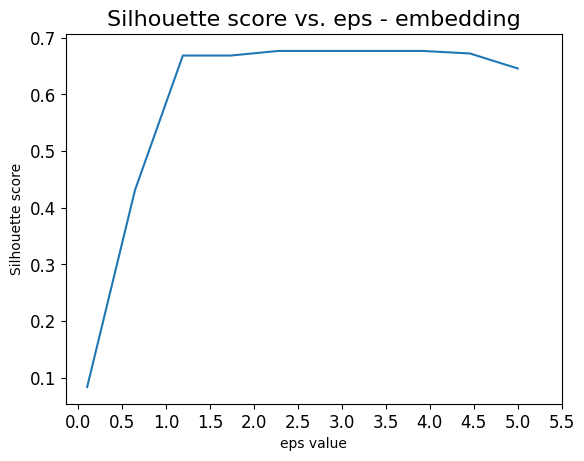

In [19]:
# Sample data
X_scaled = embedding_

# Define a range of eps values to test
eps_values = np.linspace(0.1, 5.0, 10)

# List to store the silhouette scores
silhouette_scores = []

# Compute silhouette scores for different eps values
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=20).fit(X_scaled)
    labels = db.labels_
    # Ignore the silhouette score if only one cluster or all points are noise
    if len(set(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
        # score = calinski_harabasz_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Invalid score

# Plot silhouette scores
plt.plot(eps_values, silhouette_scores)
# plt.ylabel('Silhouette Score')
plt.ylabel('Silhouette score')
plt.xlabel('eps value')
plt.xticks(np.arange(0, 6, step=0.5))
# plt.rcParams['xtick.labelsize'] = 0.7
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Silhouette score vs. eps - embedding', fontsize=16)
plt.show()

In [29]:
eps = 1.4
min_samples = 30
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
dbscan.labels_

array([0, 0, 0, ..., 5, 5, 5])

In [30]:
pd.Series(dbscan.labels_).value_counts()

 3    445
 5    438
 6    391
 0    293
 1     91
 4     88
-1     77
 2     40
Name: count, dtype: int64

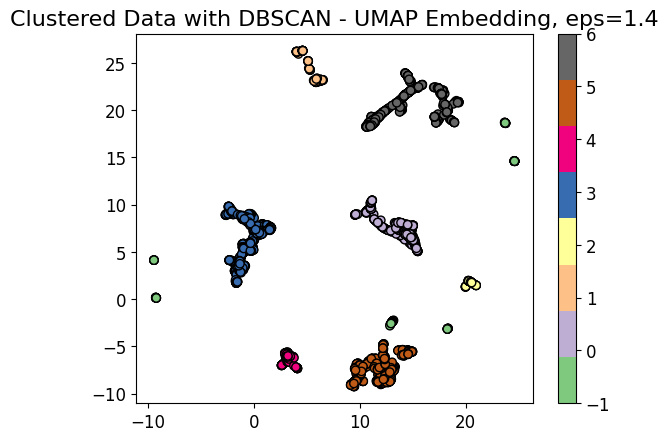

In [31]:
# Visualize the dbscan clustered data
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan.labels_, cmap='Accent', edgecolors='k')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.title(f'Clustered Data with DBSCAN - UMAP Embedding, eps={eps}', fontsize=16)
# plt.xlabel("Lactate (g/L)")
# plt.ylabel("Glucose (g/L)")
plt.tick_params(axis='both', which='major', labelsize=12)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# plt.legend()
plt.show()

In [34]:
df_normalized['Cluster'] = dbscan.labels_

In [35]:
df_normalized.to_csv('data/processed/databricks_preprocessed_forTiter_normalised_withClusters_10Feb25.csv', index=False)